# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, March 1, 2017

In [1]:
import sys
import numpy as np
from pprint import pprint as pp
import random
import pandas as pd

from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#np.random.seed(12345)

## 1. Data

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='/Users/jason/Downloads/') # Give an appropriate custom path

K = 10
D = 784

In [3]:
print (len(mnist['target']))
print (len(mnist['data']))

70000
70000


In [4]:
all_data = mnist['data']
all_labels = np.array([int(d) for d in mnist['target']])

In [5]:
# Class distribution
pd.DataFrame({'count': np.bincount(all_labels), 'digit': range(10)}, columns=['digit', 'count'])

,digit,count
0,0,6903
1,1,7877
2,2,6990
3,3,7141
4,4,6824
5,5,6313
6,6,6876
7,7,7293
8,8,6825
9,9,6958


In [6]:
def x_tilde(x):
    (batch_size, D) = x.shape
    data_tilde = np.concatenate([x, np.ones( (batch_size,1) )], axis=1)
    assert data_tilde.shape[1] == D+1
    return data_tilde

# Sampling data
num_total = 1000 # to be split into train & valid (assume we have a separate test set)

sample_idx = np.random.choice(all_data.shape[0], num_total)

data, labels = all_data[sample_idx], all_labels[sample_idx]
data_tilde = x_tilde(data)

7
2
3
9
1


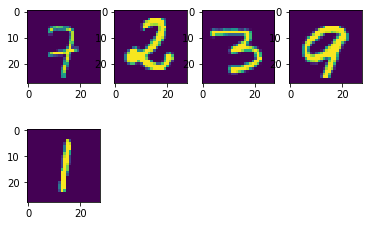

In [7]:
# Let's see how the digits look

j = 1
for i in random.sample(range(0, len(data)), 5):
    plt.subplot(2, 4, j)
    plt.imshow(data[i].reshape((28, 28)))
    print (labels[i])
    j += 1

In [8]:
print (data_tilde.shape, labels.shape)

(1000, 785) (1000,)


In [9]:
print (np.bincount(labels))

[ 88  95 124 118  99  82  93 103  97 101]


## 2. Model definition

In [10]:
def get_logits(w, data):
    # data : (batch_size, D)
    # w : (K, D)
    (K,D) = w.shape
    logits = np.matmul(data, np.transpose(w)) / D # (batch_size, K)
    return logits

def softmax(logits):
    # logits : (batch_size, K)
    logits_exp = np.exp(logits)
    all_probs = logits_exp / (np.sum(logits_exp, 1)[:,None]) # (batch_size, K)
    return all_probs

In [11]:
def eval_model(logits, labels):
    (batch_size, K) = logits.shape
    y_pred = np.argmax(logits, 1)
    right = np.sum(y_pred == labels)
    acc = right / batch_size
    return acc
    #print ("Accuracy : {:.2f}".format( right / batch_size ))

def eval_on_dataset(w, data, labels):
    (num_points, _) = data.shape
    logits = get_logits(w, data)
    all_probs = softmax(logits)
    prob = all_probs[np.arange(num_points), labels]

    cost = np.mean(distance(prob))
    acc = eval_model(logits, labels)
    return cost, acc

In [12]:
def distance(prob): # Negative Log Likelihood
    log_prob = np.log(prob + 1e-9)
    return -log_prob

In [13]:
def one_hot(batch_size, k, labels):
    output = np.zeros((batch_size, k))
    output[np.arange(batch_size), labels] = 1
    return output

def gradient(all_probs, data, labels):
    (batch_size, K) = all_probs.shape
    y_star = one_hot(batch_size, K, labels)
    grad = -1 * np.matmul( np.transpose(y_star - all_probs), data)
    # y_star - all_probs : (batch_size, K)
    # data : (batch_size, D+1)
    # grad : (K, D+1)
    return grad / batch_size

In [14]:
n_epochs = 500
batch_size = 100
lr0 = 0.1
lrf = 0.001
anneal_over = 30
patience = 5
improvement = 0.999
num_folds = 10
fold_size = int(len(data_tilde) / 10)

for each_fold in range(num_folds):
    w0 = np.random.normal(loc=0.0, scale=1.0, size=(K, D+1))
    w = np.copy(w0)
    valid_start = each_fold * fold_size
    valid_end = (each_fold+1) * fold_size
    
    valid_data_tilde = data_tilde[valid_start : valid_end, :]
    valid_labels = labels[valid_start : valid_end]
    
    train_data_tilde = np.concatenate( [ data_tilde[: valid_start, :], data_tilde[valid_end :, :]], axis=0 )
    train_labels = np.concatenate( [ labels[: valid_start], labels[valid_end :] ], axis=0)

    best_w, best_e = None, None
    old_cost = np.Inf
    val_costs = []
    for e_idx in range(n_epochs):

        for b_idx in range(int((len(data)-fold_size)/batch_size)):
            lr = max(lrf, lr0 + (lrf - lr0) * (e_idx / anneal_over) )
            #lr = lr0

            tr_data = train_data_tilde[b_idx * batch_size : (b_idx+1) * batch_size]
            tr_label = train_labels[b_idx * batch_size : (b_idx+1) * batch_size]

            logits = get_logits(w, tr_data)

            all_probs = softmax(logits)
            prob = all_probs[np.arange(batch_size), tr_label]

            cost = np.mean(distance(prob))
            grad = gradient(all_probs, tr_data, tr_label)

            w -= lr * grad

        val_cost, val_acc = eval_on_dataset(w, valid_data_tilde, valid_labels)
        #print ('epoch {:4d} : lr {:.4f} acc {:.4f} | cost {:.5f}'.format(e_idx, lr, val_acc, val_cost))

        if val_cost / old_cost <= improvement:
            best_w = w
            best_cost = val_cost
            best_e = e_idx
        else:
            print ('Fold {} converged'.format(each_fold + 1))
            val_costs.append(val_cost)
            break

        old_cost = val_cost        

print ("Average valid cost:", np.mean(val_costs))

Fold 1 converged
Fold 2 converged
Fold 3 converged
Fold 4 converged
Fold 5 converged
Fold 6 converged
Fold 7 converged
Fold 8 converged
Fold 9 converged
Fold 10 converged
Average valid cost: 1.94968200689


## 3. Feature Coefficients

In [15]:
# Shape of the coefficients learned by Logistic Regression

w.shape

(10, 785)

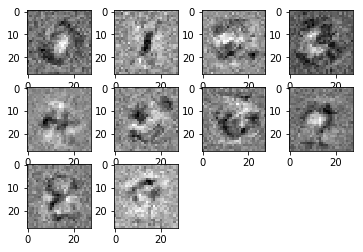

In [16]:
plt.figure()

for ii in range(w.shape[0]):
    plt.subplot(3, 4, ii+1)
    plt.imshow(w[ii,:-1].reshape(28, 28), cmap=cm.gray_r)

plt.show()